<img src="../images/AzPTravel_PPM.png">

# Audit Report

## This script reads the output of the of the final data files and compares them to inputs. 

#### Euro Check
- Compare the deltas on teh Localcurr to the source and raise errors if they do not match

#### Prior over Period Check
- Quickly compare period over period and YoY final data files for major KPI's and row counts. 



### User Variables
- These are overwritten if inherited from run_control.ipynb.
- Feel Free to reset them for a manual run if you like
- Do not save without percode = "-f"

In [2]:
commit_message = "Development and testing."
# Give a brief reason for the run.

run_control = 1
#run_type = 0 - Lite run with no reporting, not recommended.
#run_type = 1 - Lite run with normal reporting, default setting.
#run_type = 2 - Heavy run with full reporting, available for audits and troubleshooting.
#run_type = 5 - A default setting. Indicates the script is being run by an outside process without an inherited value

percode = "2021.Q1"
# Data Collection Code, this controls file paths and output names
# "-f" is the value indicating a bad inheritance from run with arg

s_format = "p"
# denotes the source data format x == Excel; j == json, p == parquet

#----------
# do not edit - this either inherits the full instance timestamp from the papermill book or captures the run time of this script.
from datetime import datetime  # datetime options
inst_datetime = datetime.now().strftime("%m%d%Y%H%M%S")

#### Notebook display options

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#### import packages

In [4]:
#### Packages used

import os # System commands
import sys # System commands

import warnings # custom warnigns options

import glob # Directory operations
import getpass # Work with parquet
import json # Work with json

import matplotlib.pyplot as plt #Plots and Graphs
import numpy as np # Series and math
import pandas as pd #DataFrame and math

#excel operations
import re
import nicexcel as nl # Excel operations
import xlsxwriter # Excel operations
import openpyxl # Excel operations


#### Default Variables, these govern logic, do not edit.

In [5]:
default_dc = "20XX.QX"
default_rc = 0 #extra lite mode
dummy_perc = "33Q3" # bad inheritance

#### Script determining run context ie, manual, run_control.ipynb, or other.

In [6]:
if run_control == 5:
    run_control = default_rc 
else:
    run_control = run_control

try:
    if sys.argv[1] == "-f":
        percode = percode
    else:
        percode = sys.argv[1]

except IndexError:
    percode = default_dc
except NameError:
    percode = default_dc


if percode == "2021.Q1":
    
     prev_percode = "2020.Q4"
     prev_yearcode = "2020.Q1"

elif percode == "2020.Q4":
    
     prev_percode = "2020.Q3"
     prev_yearcode = "2019.Q4"

elif percode == "2020.Q3":
    
     prev_percode = "2020.Q1"
     prev_yearcode = "none"    

elif percode == "2020.Q1":
    
     prev_percode = "2019.Q4"
     prev_yearcode = "none"   

#### style settings

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.float_format', lambda x: '%.5f' % x)


## Begin Input Read
- Make paths used in script
- all paths should be modular and easily replaced ahead of operations.

In [8]:
#root directory
rt_path = f'\\\\hecate\\Insurance_US\\Product Development\\Product Management\\Global PPM\\Reporting\Data Collection'

# Euro file dir
euro_conv_source_path =current_path = os.path.join(rt_path ,percode,'External Resources')

# Source file dirs
current_path = os.path.join(rt_path ,"Production" , percode)
previous_period_path = os.path.join(rt_path ,"Production" , prev_percode)
previous_year_path = os.path.join(rt_path ,"Production" , prev_yearcode )




#### Make sources used in script
- all sources should be modular and easily replaced ahead of operations.

In [9]:
if "Q1" in percode:

    EURRATES = str.replace(f"EURRATES {percode}.xlsx","Q1","03.31")

elif  "Q2" in percode:

    EURRATES = str.replace(f"EURRATES {percode}.xlsx","Q2","06.30")

elif  "Q3" in percode:

    EURRATES = str.replace(f"EURRATES {percode}.xlsx","Q2","09.30")
    
elif  "Q4" in percode:

    EURRATES = str.replace(f"EURRATES {percode}.xlsx","Q2","12.31")
    
eurrates = os.path.join( euro_conv_source_path,   EURRATES)



current_lc_file = os.path.join(current_path  ,f'{percode}.localcur.csv')
current_eur_file  = os.path.join(current_path  ,f'{percode}.euroconv.csv')

previous_period_lc_file = os.path.join(previous_period_path ,f'{ prev_percode}.localcur.csv')
previous_period_eur_file  = os.path.join(previous_period_path ,f'{ prev_percode}.euroconv.csv')

previous_year_lc_file = os.path.join(previous_year_path  ,f'{ prev_yearcode}.localcur.csv')
previous_year_eur_file  = os.path.join(previous_year_path ,f'{ prev_yearcode}.euroconv.csv')


#### import data

In [10]:
eurrates_df = pd.read_excel(eurrates,sheet_name = "Output")


current_lc_df = pd.read_csv(current_lc_file , engine='python') 
current_eur_df = pd.read_csv(current_eur_file , engine='python') 


previous_period_lc_df = pd.read_csv(previous_period_lc_file, engine='python')
previous_period_eur_df = pd.read_csv(previous_period_eur_file , engine='python')


previous_year_lc_df = pd.read_csv(previous_year_lc_file, engine='python') 
previous_year_eur_df = pd.read_csv(previous_year_eur_file , engine='python')



## Begin Audits

#### Euro Conversion Check.
- Each major KPI evaluated bu Country by Currency in the source files and the official Allianz Connect reference report.

In [11]:
attributes = ['country', 'currency']

alt_attributes = ['Country', 'Currency']

comparison_fields = [
 'written_revenues_net_of_taxes',
 'written_revenues',
 'earned_revenues_net_of_taxes',
 'earned_revenues',
 'total_compensation',
  'actual_incurred_losses_(paid_+_ocr_+_ibnr)',
 'total_expenses',
 'profit_or_loss',
]


alt_comparison_fields = [
'Written Revenues net of Taxes',
 'Written Revenues',
 'Earned Revenues net of Taxes',
 'Earned Revenues',
 'Total Compensation',
 'Actual Incurred Losses (Paid + OCR + IBNR)',
 'Total Expenses',
 'Profit or Loss',
]

view_cols = [] 

for a in attributes: view_cols.append(a)
for c in comparison_fields: view_cols.append(c)

    
    
alt_view_cols = [] 

for a in alt_attributes: alt_view_cols.append(a)
for c in alt_comparison_fields: alt_view_cols.append(c)
    

current_eur_view =  current_eur_df[view_cols].groupby(attributes).sum()

try:
    current_lc_view =  current_lc_df[view_cols].groupby(attributes).sum()

except KeyError:
    current_lc_view =  current_lc_df[alt_view_cols].groupby(alt_attributes).sum()  
    

previous_period_eur_view =  previous_period_eur_df[view_cols].groupby(attributes).sum()    
previous_year_eur_view =  previous_year_eur_df[view_cols].groupby(attributes).sum()    




#### Make a list of BUs that have comments available

In [12]:

calculated_rates = current_lc_view.div(current_eur_view).reset_index()

calculated_rates = calculated_rates.melt(id_vars=attributes).reset_index(drop = True)

calculated_rates = calculated_rates[["country","currency", "value"]]

calculated_rates['value'] = calculated_rates['value'].round(5)

calculated_rates = calculated_rates.drop_duplicates()[calculated_rates['value'].notna()]
calculated_rates 

C:\Users\gharmo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


country currency   value
0      AU      AUD 1.54310
1      CA      CAD 1.47720
2      CH      CHF 1.10615
3      CZ      EUR 1.00000
4      ES      EUR 1.00000
5      GR      EUR 1.00000
6      IT      EUR 1.00000
7      NL      EUR 1.00000
8      PL      EUR 1.00000
9      PT      EUR 1.00000

In [13]:
test = 1

if calculated_rates.groupby( attributes).count()['value'].max() != 1: 
    
    test = 0

else:
    
    pass
        
        
1/test # if this is an error you have bad currency conversions and possibly a bad join with extra rows

#todo build a proper error class

1.0

In [14]:

test = 1

if len(current_eur_df[attributes].drop_duplicates()) != len(calculated_rates): 
    
    test = 0

else:
    pass

1/test # if this is an error you do not have the same number of country and curreny combos in all views. Major problem!

#todo build a proper error class



1.0

In [15]:
conversion_comparison =  calculated_rates.merge( eurrates_df,  how='left',  left_on='currency', right_on='CurrCode' )

conversion_comparison



country currency   value CurrCode       Country  EUR_2_LC  LC_2_EUR
0      AU      AUD 1.54310      AUD    Australia    1.54310   0.64805
1      CA      CAD 1.47720      CAD        Canada   1.47720   0.67696
2      CH      CHF 1.10615      CHF  Switzerland    1.10615   0.90404
3      CZ      EUR 1.00000      EUR         Euro    1.00000   1.00000
4      ES      EUR 1.00000      EUR         Euro    1.00000   1.00000
5      GR      EUR 1.00000      EUR         Euro    1.00000   1.00000
6      IT      EUR 1.00000      EUR         Euro    1.00000   1.00000
7      NL      EUR 1.00000      EUR         Euro    1.00000   1.00000
8      PL      EUR 1.00000      EUR         Euro    1.00000   1.00000
9      PT      EUR 1.00000      EUR         Euro    1.00000   1.00000

In [16]:

test = 1

if (   conversion_comparison['value']   - conversion_comparison['EUR_2_LC']).sum() != 0: 
    
    test = 0

else:
    pass

1/test # if this is an error you do not match the source currency document. Major problem!

#todo build a proper error class


1.0

In [17]:
# current_eur_view = current_eur_view.reset_index()
# previous_period_eur_view = previous_period_eur_view.reset_index()
# previous_year_eur_view = previous_year_eur_view.reset_index()





In [18]:
current_eur_view['Period'] = percode
previous_period_eur_view['Period']  =    prev_percode 
previous_year_eur_view['Period']    =  prev_yearcode 



In [19]:
combo_views = current_eur_view.append(previous_period_eur_view).append(previous_year_eur_view)

combo_views

written_revenues_net_of_taxes  written_revenues  \
country currency                                                    
AU      AUD                         91686.79036           0.00000   
CA      CAD                       6774281.88465     6804054.73869   
CH      CHF                      27181112.76952           0.00000   
CZ      EUR                        384837.67228      384837.67228   
ES      EUR                        892391.41000      965121.30991   
...                                         ...               ...   
PL      EUR                       7338567.83355     7338567.83355   
PT      EUR                        178994.56000      172085.95000   
SE      EUR                       3212611.00000           0.00000   
UK      GBP                       6355643.44026     7423949.64020   
US      USD                    1137304643.72749  1137304643.72749   

                  earned_revenues_net_of_taxes  earned_revenues  \
country currency                                                  
AU      AUD                      9332572.90584          0.00000   
CA      CAD                      7906948.34916          0.00000   
CH      CHF                     31246379.71907          0.00000   
CZ      EUR                       387392.03675     387392.03675   
ES      EUR                       736249.62000     796253.96403   
...                                        ...              ...   
PL      EUR                      5589756.43733    5589756.43733   
PT      EUR                       175055.42872     164756.71451   
SE      EUR                      3073854.00000          0.00000   
UK      GBP                      4977416.07375    5818779.66926   
US      USD                   1122964702.66575 1122964702.66575   

                  total_compensation  \
country currency                       
AU      AUD             216127.95390   
CA      CAD            2233722.50171   
CH      CHF            7519635.50344   
CZ      EUR             173009.34150   
ES      EUR             339080.99000   
...                              ...   
PL      EUR            2641837.05568   
PT      EUR              10856.48738   
SE      EUR            1805938.00000   
UK      GBP            1469592.50285   
US      USD          539043173.76167   

                  actual_incurred_losses_(paid_+_ocr_+_ibnr)  total_expenses  \
country currency                                                               
AU      AUD                                    1811872.66040   4832421.23620   
CA      CAD                                    4417080.28482   1771533.24975   
CH      CHF                                    5470941.93045   8826348.84822   
CZ      EUR                                     274986.98315     59407.91877   
ES      EUR                                     148353.17357    284146.93991   
...                                                      ...             ...   
PL      EUR                                    2957760.75136   1164651.95704   
PT      EUR                                      45381.81000     54961.74333   
SE      EUR                                     606724.00000    234227.67480   
UK      GBP                                    1855749.44906    839809.12021   
US      USD                                  330595032.02552 214503449.99772   

                  profit_or_loss   Period  
country currency                           
AU      AUD        2472151.05534  2021.Q1  
CA      CAD        -515387.68713  2021.Q1  
CH      CHF        9429453.43697  2021.Q1  
CZ      EUR        -120012.20667  2021.Q1  
ES      EUR         -35331.48348  2021.Q1  
...                          ...      ...  
PL      EUR       -1174493.32674  2020.Q1  
PT      EUR          63855.38801  2020.Q1  
SE      EUR         426964.32520  2020.Q1  
UK      GBP         812265.00162  2020.Q1  
US      USD       38823046.88084  2020.Q1  

[69 rows x 9 columns]

In [20]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter(
    x=combo_views['earned_revenues_net_of_taxes'],
    mode='markers', y=combo_views['actual_incurred_losses_(paid_+_ocr_+_ibnr)'],
    marker_size=(combo_views['profit_or_loss']/500000).abs())
])

fig.show()

In [21]:
a =1 
print(a)


1


In [22]:
import plotly.graph_objects as go
x_list = ['2013','The Russian <br>Macroeconomy', 'Decline in working age<br>population','Internet usage growth','Development of<br>cross-border trade', 'National companies', '2014']
y_list = [738.5, 48.7, -7.4, 68.7, 99.7, 48.0]
total = round(sum(y_list))
y_list.append(total)

In [23]:
text_list = []
for index, item in enumerate(y_list):
    if item > 0 and index != 0 and index != len(y_list) - 1:
        text_list.append(f'+{str(y_list[index])}')
    else:
        text_list.append(str(y_list[index]))
for index, item in enumerate(text_list):
    if item[0] == '+' and index != 0 and index != len(text_list) - 1:
        text_list[index] = '<span style="color:#2ca02c">' + text_list[index] + '</span>'
    elif item[0] == '-' and index != 0 and index != len(text_list) - 1:
        text_list[index] = '<span style="color:#d62728">' + text_list[index] + '</span>'
    if index == 0 or index == len(text_list) - 1:
        text_list[index] = '<b>' + text_list[index] + '</b>'

In [24]:
dict_list = []
for i in range(0, 1200, 200):
    dict_list.append(dict(
            type="line",
            line=dict(
                 color="#666666",
                 dash="dot"
            ),
            x0=-0.5,
            y0=i,
            x1=6,
            y1=i,
            line_width=1,
            layer="below"))

In [25]:
fig = go.Figure(go.Waterfall(
    name = "e-commerce", orientation = "v",
    measure = ["absolute", "relative", "relative", "relative", "relative", "relative", "total"],
    x = x_list,
    y = y_list,
    text = text_list,
    textposition = "outside",
    connector = {"line":{"color":'rgba(0,0,0,0)'}},
    increasing = {"marker":{"color":"#2ca02c"}},
    decreasing = {"marker":{"color":"#d62728"}},
    totals={'marker':{"color":"#9467bd"}},
    textfont={"family":"Open Sans, light",
              "color":"black"
             }
))

In [26]:
fig.update_layout(
    title = 
        {'text':'<b>Waterfall chart</b><br><span style="color:#666666">E-commerce market growth from 2013 to 2014</span>'},
    showlegend = False,
    height=650,
    font={
        'family':'Open Sans, light',
        'color':'black',
        'size':14
    },
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis_title="млрд руб.",
    shapes=dict_list
)
fig.update_xaxes(tickangle=-45, tickfont=dict(family='Open Sans, light', color='black', size=14))
fig.update_yaxes(tickangle=0, tickfont=dict(family='Open Sans, light', color='black', size=14))

fig.show()

In [27]:
### Open the folder with the documents saved

In [28]:
  Recalled    Recovered
  11.472  10.207
  11.810  10.326
  10.632  10.094
  13.857  12.944
  13.861  12.588
  13.375  11.951
  11.278  nan
  12.827  nan
  12.687  nan
  10.859  nan
  nan      nan
  11.782  11.047
  12.089  10.194
  14.351  13.401
  14.921  13.886
  11.759  10.815
  12.987  11.482
  13.262  10.730
  9.980   9.520
  10.626  9.591
  12.199  10.270

SyntaxError: invalid syntax (<ipython-input-28-dbb718d06f07>, line 1)

In [ ]:
example = {}

year =  [ '1994',  
'1995',  
'1996',  
'1997',  
'1998',  
'1999',  
'2000',  
'2001',  
'2002',  
'2003',  
'2004',  
'2005',  
'2006',  
'2007',  
'2008',  
'2009',  
'2010',  
'2011',  
'2012',  
'2013',  
'2014']

Recalled = [11.472,
11.810,
10.632,
13.857,
13.861,
13.375,
11.278,
12.827,
12.687,
10.859,
None            ,11.782,
12.089,
14.351,
14.921,
11.759,
12.987,
13.262,
9.980 ,
10.626,
12.199]

Recovered = [
10.207,
10.326,
10.094,
12.944,
12.588,
11.951,None  ,None  ,None  ,None  ,None  ,11.047,
10.194,
13.401,
13.886,
10.815,
11.482,
10.730,
9.520,
9.591,
10.270]







example.update( {'year' : year,'Recalled' : Recalled  ,'Recovered' :Recovered })

example


In [ ]:
combo_views = combo_views.reset_index()


In [ ]:

print(combo_views['Period'].drop_duplicates().values)

In [ ]:
list(combo_views.columns.values)

In [ ]:
row = list(combo_views[:1].values[0])

row

for item in row: 
    
    try: 
        float(item)
        
    except ValueError:
        row.remove(item)

row




In [31]:
a = list( combo_views[(combo_views['Period'] == percode) & (combo_views.index.get_level_values('country')  == 'AU')].values[0])
b = list( combo_views[(combo_views['Period'] == percode) & (combo_views.index.get_level_values('country')  == 'AU')].values[0][0:-1])



[91686.79035707343,
 0.0,
 9332572.905838896,
 0.0,
 216127.95390447808,
 1811872.6604017804,
 4832421.236196707,
 2472151.055335932,
 '2021.Q1']

[91686.79035707343,
 0.0,
 9332572.905838896,
 0.0,
 216127.95390447808,
 1811872.6604017804,
 4832421.236196707,
 2472151.055335932]

In [36]:
list( combo_views[(combo_views['Period'] == previous_year_eur_view) & (combo_views.index.get_level_values('country')  == 'AU')].values[0][0:-1])



ValueError: cannot join with no overlapping index names

In [53]:
combo_views.index.get_level_values('country')  == 'AU'


previous_year_eur_view

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

written_revenues_net_of_taxes  written_revenues  \
country currency                                                    
AT      EUR                       5804936.87142           0.00000   
AU      AUD                     104186913.66242           0.00000   
CA      CAD                     125388358.55910    51649053.17201   
CH      CHF                      41629683.45500           0.00000   
CN      CNY                       5966448.99793           0.00000   
DE      EUR                     152294266.26250   172565813.86004   
DK      EUR                       1857033.00000           0.00000   
EE      EUR                          1645.00000           0.00000   
ES      EUR                       2387257.79000     2534074.14409   
FI      EUR                        580081.00000           0.00000   
FOS     EUR                       8551025.79000           0.00000   
GR      EUR                       1781869.26000     1999329.84350   
IS      EUR                         56815.00000           0.00000   
IT      EUR                      47948719.13000    53267949.62000   
LT      EUR                          2330.00000           0.00000   
LV      EUR                          1378.00000           0.00000   
NL      EUR                      50971228.00000           0.00000   
NO      EUR                       1067548.00000           0.00000   
NZ      NZD                      50380375.30716    50380375.30716   
PL      EUR                       7338567.83355     7338567.83355   
PT      EUR                        178994.56000      172085.95000   
SE      EUR                       3212611.00000           0.00000   
UK      GBP                       6355643.44026     7423949.64020   
US      USD                    1137304643.72749  1137304643.72749   

                  earned_revenues_net_of_taxes  earned_revenues  \
country currency                                                  
AT      EUR                      5804936.87142          0.00000   
AU      AUD                    106935498.38343          0.00000   
CA      CAD                    130091904.70395   47549727.12787   
CH      CHF                     40587563.13050          0.00000   
CN      CNY                      6753891.89287          0.00000   
DE      EUR                    155673072.39250  176560191.14993   
DK      EUR                      1882828.00000          0.00000   
EE      EUR                         1769.00000          0.00000   
ES      EUR                      1975334.00000    2096817.04100   
FI      EUR                       721658.00000          0.00000   
FOS     EUR                      9841727.93000          0.00000   
GR      EUR                      2016485.31000    2268643.15700   
IS      EUR                        57707.00000          0.00000   
IT      EUR                     51185811.92662   56913542.54133   
LT      EUR                         2429.00000          0.00000   
LV      EUR                         2116.00000          0.00000   
NL      EUR                     50688323.00000          0.00000   
NO      EUR                      1090555.00000          0.00000   
NZ      NZD                     52107138.05541   52107138.05541   
PL      EUR                      5589756.43733    5589756.43733   
PT      EUR                       175055.42872     164756.71451   
SE      EUR                      3073854.00000          0.00000   
UK      GBP                      4977416.07375    5818779.66926   
US      USD                   1122964702.66575 1122964702.66575   

                  total_compensation  \
country currency                       
AT      EUR            1602696.57874   
AU      AUD           22544552.48010   
CA      CAD           37355827.73366   
CH      CHF            9468425.12952   
CN      CNY            2939196.92736   
DE      EUR           47024828.54500   
DK      EUR            1064879.00000   
EE      EUR                674.00000   
ES      EUR             798604.35000   
FI      EUR             354424.00000   


In [47]:
list( combo_views[(combo_views['Period'] == percode) & (combo_views.index.get_level_values('country')  == 'AU')].values[0][0:-1])

list( combo_views[(combo_views['Period'] == prev_percode) & (combo_views.index.get_level_values('country')  == 'AU')].values[0][0:-1])
 
list([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,])

list(combo_views.columns.values)

[91686.79035707343,
 0.0,
 9332572.905838896,
 0.0,
 216127.95390447808,
 1811872.6604017804,
 4832421.236196707,
 2472151.055335932]

[45828590.74192734,
 0.0,
 68094825.02699292,
 0.0,
 7494643.141379916,
 33241364.38777794,
 29566561.44677093,
 -2207743.9489358524]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

['written_revenues_net_of_taxes',
 'written_revenues',
 'earned_revenues_net_of_taxes',
 'earned_revenues',
 'total_compensation',
 'actual_incurred_losses_(paid_+_ocr_+_ibnr)',
 'total_expenses',
 'profit_or_loss',
 'Period']

In [82]:

from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure

output_file("bars.html")


for b in set(combo_views.index.get_level_values('country')) :

    output_file(f"bars{b}.html")
    
    try:
        percode_row  =list( combo_views[(combo_views['Period'] == percode) & (combo_views.index.get_level_values('country')  == b)].values[0][0:-1])

    except:
        percode_row = list([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,])

    try:
        prev_percode_row =list( combo_views[(combo_views['Period'] == prev_percode) & (combo_views.index.get_level_values('country')  == b)].values[0][0:-1])

    except:
        prev_percode_row = list([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,])

    try:
        previous_year_eur_row =list( combo_views[(combo_views['Period'] == prev_yearcode) & (combo_views.index.get_level_values('country')  == b)].values[0][0:-1])

    except:
        previous_year_eur_row = list([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,])

    if sum(percode_row)  == 0:
        
        True == True
    
    else:
    

        fruits = list(combo_views.columns.values)[0:-1]
        years = combo_views['Period'].drop_duplicates().values

        data = {'fruits' : fruits,
                percode  : percode_row ,
                    prev_percode  : prev_percode_row    ,      
                    prev_yearcode  : previous_year_eur_row
               }

        x = [ (fruit, year) for fruit in fruits for year in years ]
        counts = sum(zip(data[percode], data[prev_percode], data[prev_yearcode ]), ()) # like an hstack

        source = ColumnDataSource(data=dict(x=x, counts=counts))

        p = figure(x_range=FactorRange(*x), plot_height=250, title=f"{b}",
                   toolbar_location=None, tools="")

        p.vbar(x='x', top='counts', width=0.9, source=source)

        p.y_range.start = 0
        p.x_range.range_padding = 0.1
        p.xaxis.major_label_orientation = 1
        p.xgrid.grid_line_color = None

        show(p)

True

True

True

True

True

True

True

True

True

GlyphRenderer(id='12256', ...)

ValueError: "Invalid object to show. The object to passed to show must be one of:

* a LayoutDOM (e.g. a Plot or Widget or Layout)
* a Bokeh Application
* a callable suitable to an application FunctionHandler


In [61]:
list( combo_views[(combo_views['Period'] == percode) & (combo_views.index.get_level_values('country')  == 'AU')].values[0][0:-1])
combo_views

[91686.79035707343,
 0.0,
 9332572.905838896,
 0.0,
 216127.95390447808,
 1811872.6604017804,
 4832421.236196707,
 2472151.055335932]

written_revenues_net_of_taxes  written_revenues  \
country currency                                                    
AU      AUD                         91686.79036           0.00000   
CA      CAD                       6774281.88465     6804054.73869   
CH      CHF                      27181112.76952           0.00000   
CZ      EUR                        384837.67228      384837.67228   
ES      EUR                        892391.41000      965121.30991   
...                                         ...               ...   
PL      EUR                       7338567.83355     7338567.83355   
PT      EUR                        178994.56000      172085.95000   
SE      EUR                       3212611.00000           0.00000   
UK      GBP                       6355643.44026     7423949.64020   
US      USD                    1137304643.72749  1137304643.72749   

                  earned_revenues_net_of_taxes  earned_revenues  \
country currency                                                  
AU      AUD                      9332572.90584          0.00000   
CA      CAD                      7906948.34916          0.00000   
CH      CHF                     31246379.71907          0.00000   
CZ      EUR                       387392.03675     387392.03675   
ES      EUR                       736249.62000     796253.96403   
...                                        ...              ...   
PL      EUR                      5589756.43733    5589756.43733   
PT      EUR                       175055.42872     164756.71451   
SE      EUR                      3073854.00000          0.00000   
UK      GBP                      4977416.07375    5818779.66926   
US      USD                   1122964702.66575 1122964702.66575   

                  total_compensation  \
country currency                       
AU      AUD             216127.95390   
CA      CAD            2233722.50171   
CH      CHF            7519635.50344   
CZ      EUR             173009.34150   
ES      EUR             339080.99000   
...                              ...   
PL      EUR            2641837.05568   
PT      EUR              10856.48738   
SE      EUR            1805938.00000   
UK      GBP            1469592.50285   
US      USD          539043173.76167   

                  actual_incurred_losses_(paid_+_ocr_+_ibnr)  total_expenses  \
country currency                                                               
AU      AUD                                    1811872.66040   4832421.23620   
CA      CAD                                    4417080.28482   1771533.24975   
CH      CHF                                    5470941.93045   8826348.84822   
CZ      EUR                                     274986.98315     59407.91877   
ES      EUR                                     148353.17357    284146.93991   
...                                                      ...             ...   
PL      EUR                                    2957760.75136   1164651.95704   
PT      EUR                                      45381.81000     54961.74333   
SE      EUR                                     606724.00000    234227.67480   
UK      GBP                                    1855749.44906    839809.12021   
US      USD                                  330595032.02552 214503449.99772   

                  profit_or_loss   Period  
country currency                           
AU      AUD        2472151.05534  2021.Q1  
CA      CAD        -515387.68713  2021.Q1  
CH      CHF        9429453.43697  2021.Q1  
CZ      EUR        -120012.20667  2021.Q1  
ES      EUR         -35331.48348  2021.Q1  
...                          ...      ...  
PL      EUR       -1174493.32674  2020.Q1  
PT      EUR          63855.38801  2020.Q1  
SE      EUR         426964.32520  2020.Q1  
UK      GBP         812265.00162  2020.Q1  
US      USD       38823046.88084  2020.Q1  

[69 rows x 9 columns]

In [ ]:
fig = go.Figure(data=[go.Scatter(
    x=combo_views['earned_revenues_net_of_taxes'],
    mode='markers', y=combo_views['actual_incurred_losses_(paid_+_ocr_+_ibnr)'],
    marker_size=(combo_views['profit_or_loss']/500000).abs())
                      
                      
                      
		written_revenues_net_of_taxes	written_revenues	earned_revenues_net_of_taxes	earned_revenues	total_compensation	actual_incurred_losses_(paid_+_ocr_+_ibnr)	total_expenses	profit_or_loss	currency
country	currency	
                      

In [66]:
set(combo_views.index.get_level_values('country'))

{'AT',
 'AU',
 'BE',
 'BG',
 'CA',
 'CH',
 'CN',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'ES',
 'FI',
 'FOS',
 'FR',
 'GR',
 'HU',
 'IE',
 'IS',
 'IT',
 'LT',
 'LU',
 'LV',
 'NL',
 'NO',
 'NZ',
 'PL',
 'PT',
 'RO',
 'SE',
 'SI',
 'SK',
 'UK',
 'US'}

In [ ]:
os.startfile(rep_path)

In [101]:
combo_views[0:][1:]

written_revenues_net_of_taxes  written_revenues  \
country currency                                                    
CA      CAD                       6774281.88465     6804054.73869   
CH      CHF                      27181112.76952           0.00000   
CZ      EUR                        384837.67228      384837.67228   
ES      EUR                        892391.41000      965121.30991   
GR      EUR                        137575.55000      153041.78150   
...                                         ...               ...   
PL      EUR                       7338567.83355     7338567.83355   
PT      EUR                        178994.56000      172085.95000   
SE      EUR                       3212611.00000           0.00000   
UK      GBP                       6355643.44026     7423949.64020   
US      USD                    1137304643.72749  1137304643.72749   

                  earned_revenues_net_of_taxes  earned_revenues  \
country currency                                                  
CA      CAD                      7906948.34916          0.00000   
CH      CHF                     31246379.71907          0.00000   
CZ      EUR                       387392.03675     387392.03675   
ES      EUR                       736249.62000     796253.96403   
GR      EUR                       109622.52000     120634.79300   
...                                        ...              ...   
PL      EUR                      5589756.43733    5589756.43733   
PT      EUR                       175055.42872     164756.71451   
SE      EUR                      3073854.00000          0.00000   
UK      GBP                      4977416.07375    5818779.66926   
US      USD                   1122964702.66575 1122964702.66575   

                  total_compensation  \
country currency                       
CA      CAD            2233722.50171   
CH      CHF            7519635.50344   
CZ      EUR             173009.34150   
ES      EUR             339080.99000   
GR      EUR              42336.64000   
...                              ...   
PL      EUR            2641837.05568   
PT      EUR              10856.48738   
SE      EUR            1805938.00000   
UK      GBP            1469592.50285   
US      USD          539043173.76167   

                  actual_incurred_losses_(paid_+_ocr_+_ibnr)  total_expenses  \
country currency                                                               
CA      CAD                                    4417080.28482   1771533.24975   
CH      CHF                                    5470941.93045   8826348.84822   
CZ      EUR                                     274986.98315     59407.91877   
ES      EUR                                     148353.17357    284146.93991   
GR      EUR                                      19892.67000     24823.45580   
...                                                      ...             ...   
PL      EUR                                    2957760.75136   1164651.95704   
PT      EUR                                      45381.81000     54961.74333   
SE      EUR                                     606724.00000    234227.67480   
UK      GBP                                    1855749.44906    839809.12021   
US      USD                                  330595032.02552 214503449.99772   

                  profit_or_loss   Period  
country currency                           
CA      CAD        -515387.68713  2021.Q1  
CH      CHF        9429453.43697  2021.Q1  
CZ      EUR        -120012.20667  2021.Q1  
ES      EUR         -35331.48348  2021.Q1  
GR      EUR          22569.75420  2021.Q1  
...                          ...      ...  
PL      EUR       -1174493.32674  2020.Q1  
PT      EUR          63855.38801  2020.Q1  
SE      EUR         426964.32520  2020.Q1  
UK      GBP         812265.00162  2020.Q1  
US      USD       38823046.88084  2020.Q1  

[68 rows x 9 columns]

In [116]:
rs_cv = combo_views.reset_index()

melt_cv = rs_cv.melt(['country','Period','currency'])

# melt_cv

melt_cv['value'] = melt_cv['value'].fillna(0)

melt_cv


country   Period currency                       variable          value
0        AU  2021.Q1      AUD  written_revenues_net_of_taxes    91686.79036
1        CA  2021.Q1      CAD  written_revenues_net_of_taxes  6774281.88465
2        CH  2021.Q1      CHF  written_revenues_net_of_taxes 27181112.76952
3        CZ  2021.Q1      EUR  written_revenues_net_of_taxes   384837.67228
4        ES  2021.Q1      EUR  written_revenues_net_of_taxes   892391.41000
..      ...      ...      ...                            ...            ...
547      PL  2020.Q1      EUR                 profit_or_loss -1174493.32674
548      PT  2020.Q1      EUR                 profit_or_loss    63855.38801
549      SE  2020.Q1      EUR                 profit_or_loss   426964.32520
550      UK  2020.Q1      GBP                 profit_or_loss   812265.00162
551      US  2020.Q1      USD                 profit_or_loss 38823046.88084

[552 rows x 5 columns]

In [119]:
melt_cv['value'] = abs(melt_cv['value'])


In [121]:
import plotly.express as px


fig = px.bar(melt_cv, x="variable", color="country",
             y='value',
             title="A Grouped Bar Chart With Plotly Express in Python",
             barmode='group',
             height=700,
             facet="country"
            )

fig.show()

TypeError: bar() got an unexpected keyword argument 'facet'

In [122]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timeit

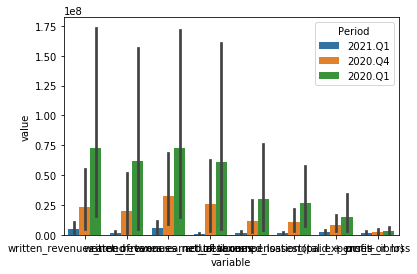

In [135]:
ax = sns.barplot(y="value", x="variable", hue="Period" ,data=melt_cv)

In [126]:
g = sns.FacetGrid(melt_cv, row="country", col='variable') 
g.map(sns.barplot,'value')
plt.show()

KeyboardInterrupt: 

ValueError: Image size of 1728x96984 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1728x96984 with 2225 Axes>

KeyboardInterrupt: 

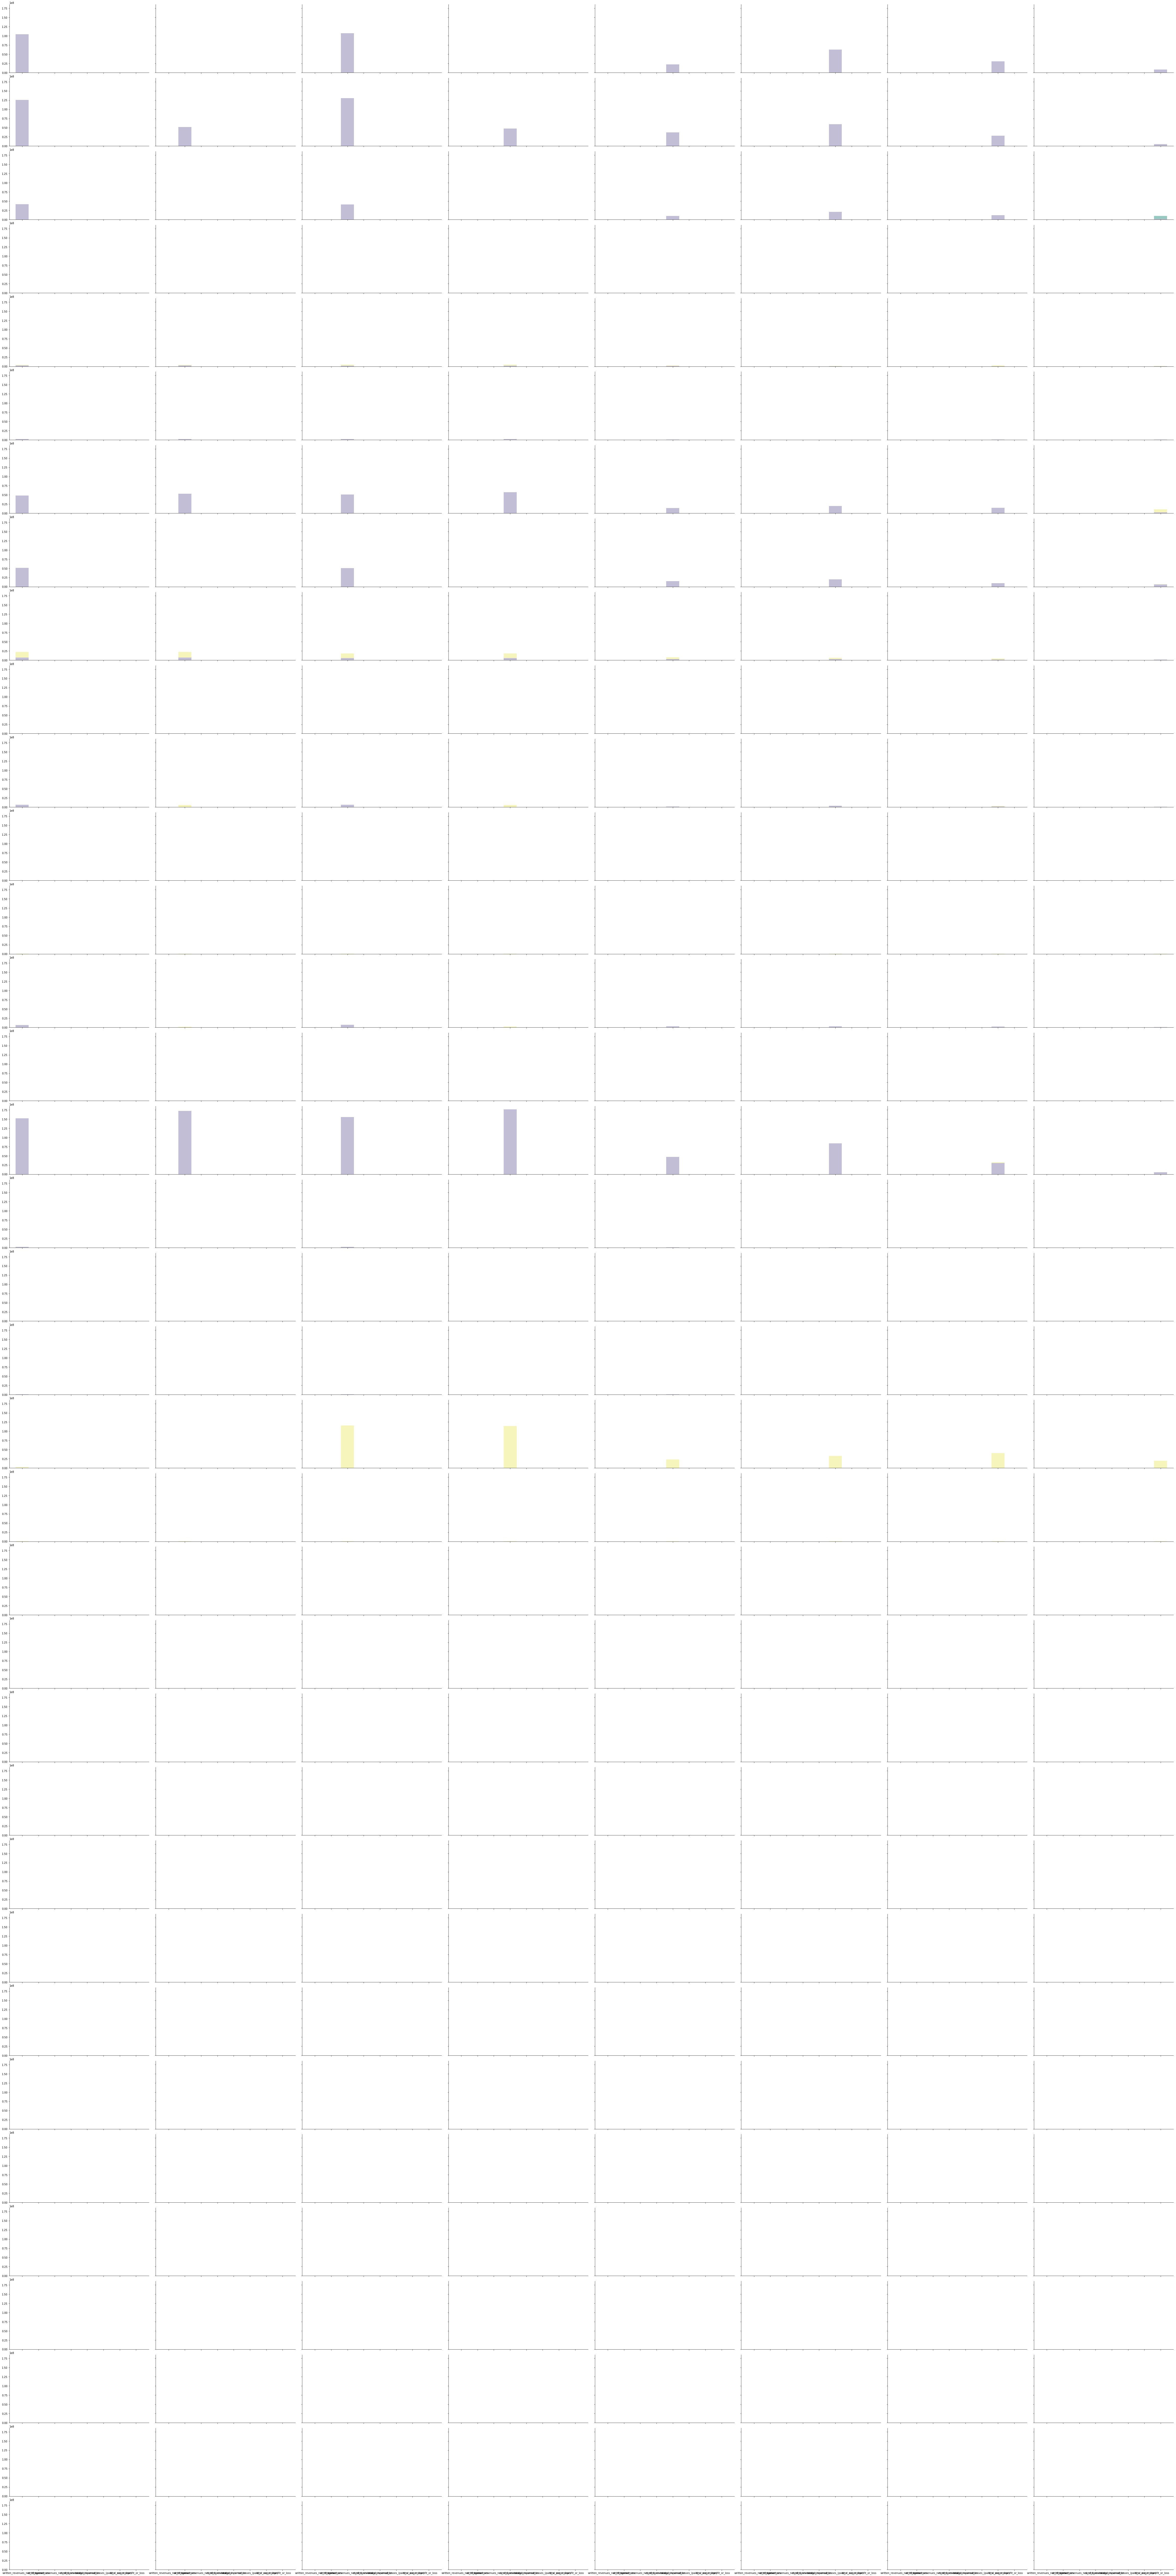

In [144]:

order = melt_cv.variable.unique()

g = sns.FacetGrid(melt_cv, row="country", col="variable",   hue="Period",
                  palette="Set3" , height=4, aspect=2)
                 

g.map(sns.barplot,  'variable','value', order =order)


In [196]:
check_set0 = melt_cv[melt_cv["Period"] == percode].groupby( ["country"]).sum()

include = check_set0.index.values

include = list(include)

melt_cv = melt_cv[melt_cv["country"].isin(include)]


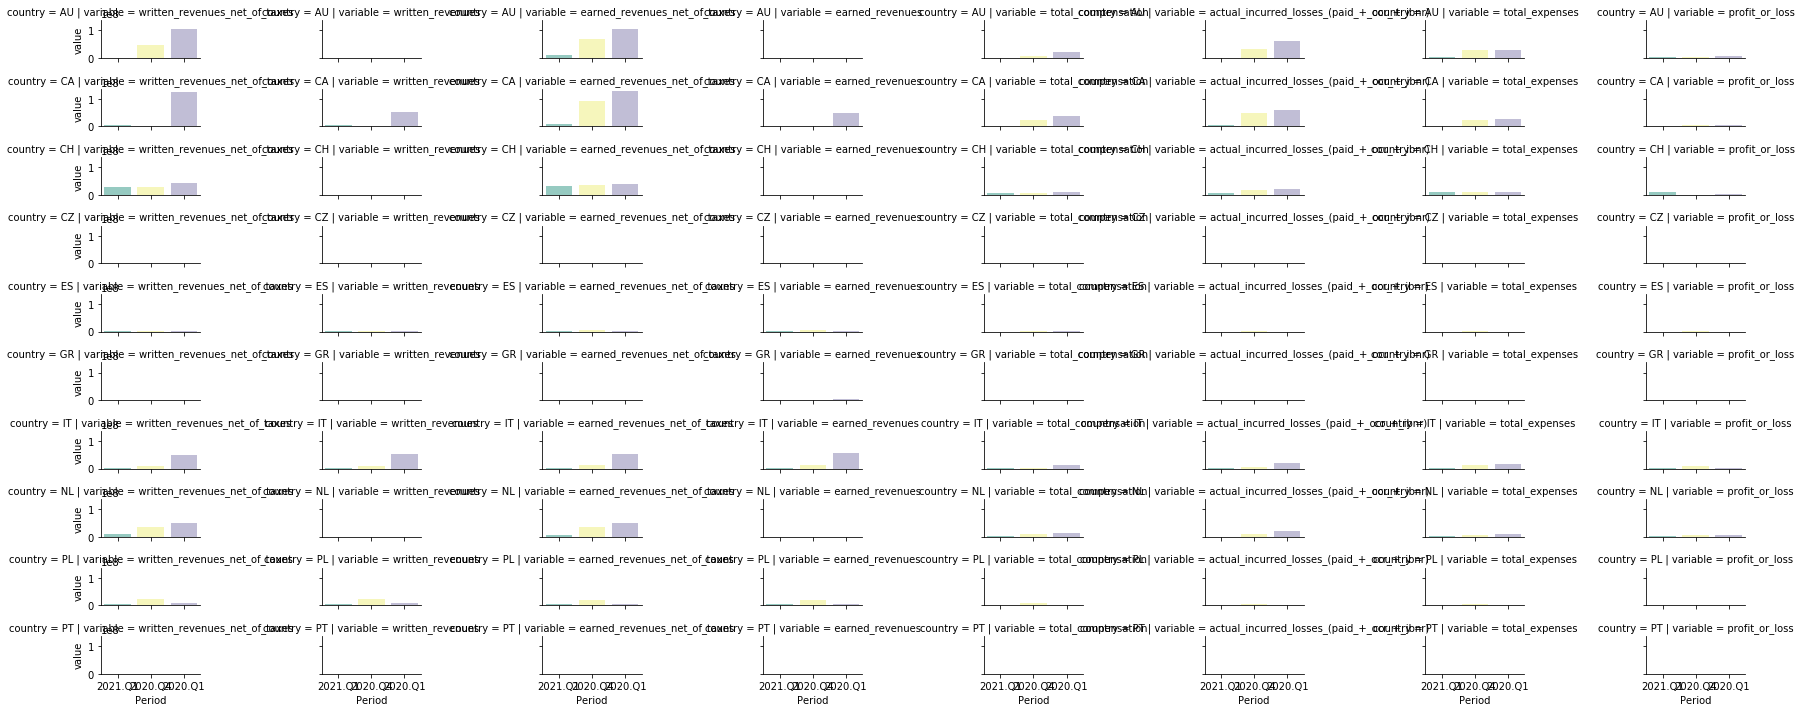

In [215]:
#changed variable to period
order = melt_cv.Period.unique()

g = sns.FacetGrid(melt_cv, row="country", col= "variable",  hue="Period", palette="Set3" ,  height=1, aspect=3)
g.map(sns.barplot, "Period", "value", order=order)

written_revenues_net_of_taxes


written_revenues


earned_revenues_net_of_taxes


earned_revenues


total_compensation


actual_incurred_losses_(paid_+_ocr_+_ibnr)


total_expenses


profit_or_loss


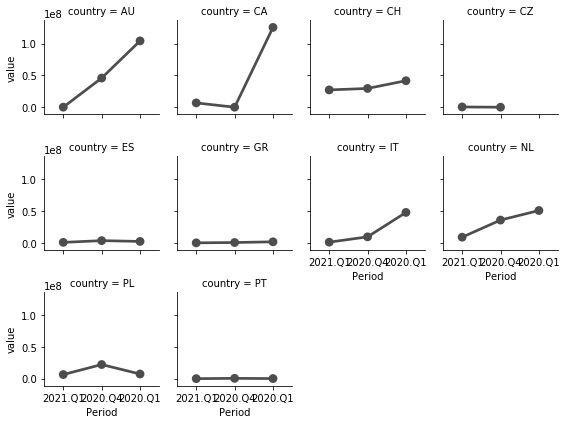

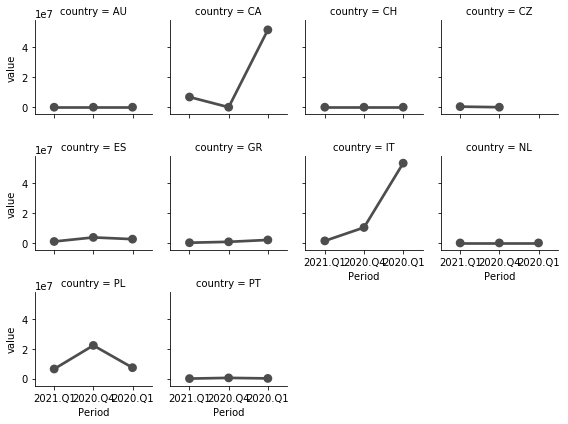

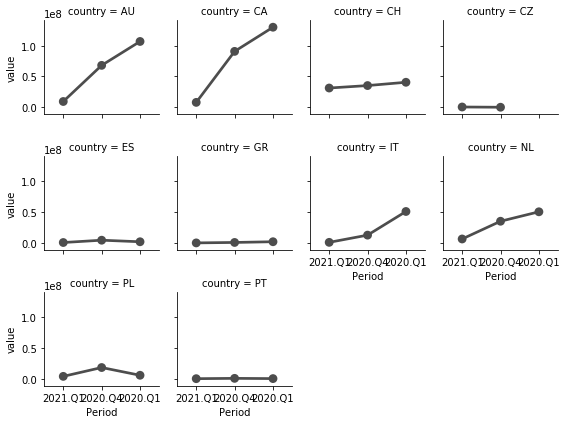

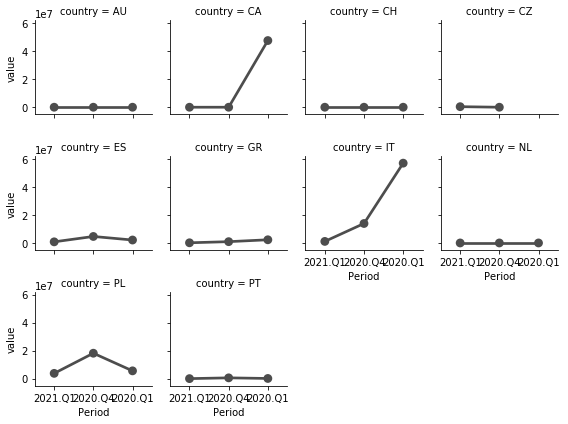

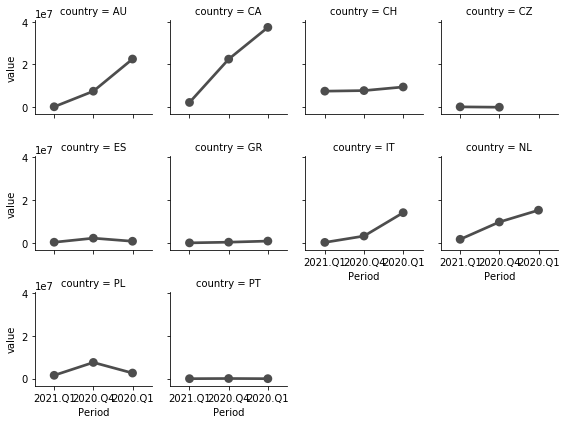

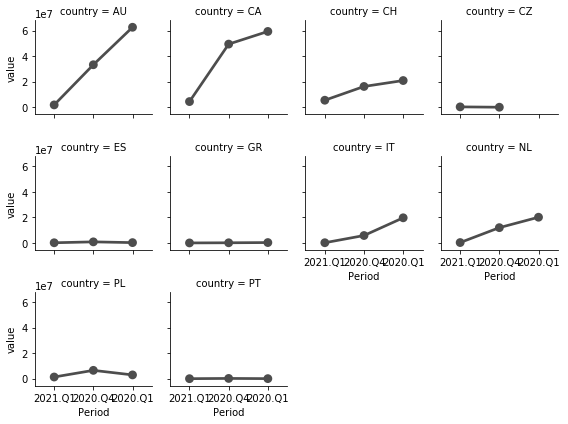

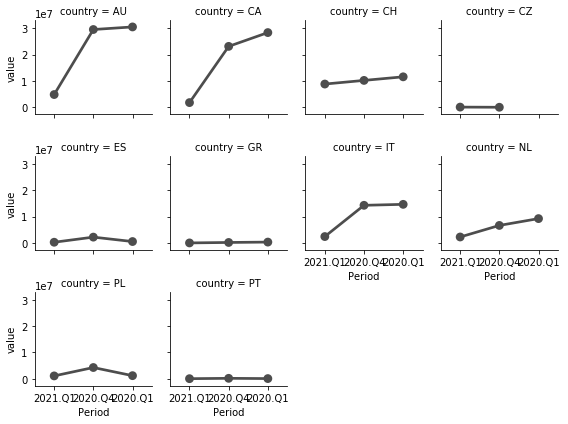

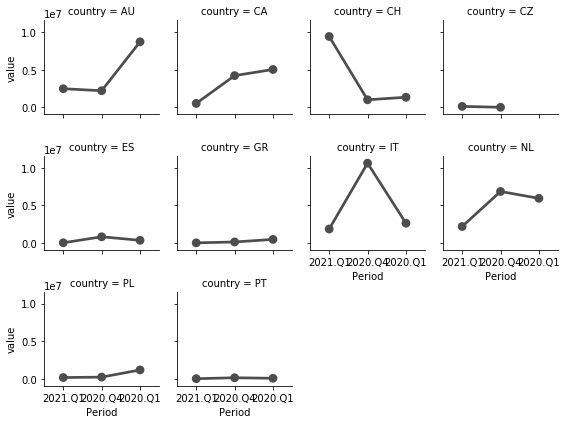

In [205]:

for f in comparison_fields:
    
    print(f)
    attend = melt_cv[melt_cv["variable"]== f ]
    g = sns.FacetGrid(attend, col="country", col_wrap=4, height=2, )
    g.map(sns.pointplot, "Period", "value", order=order, color=".3", ci=None)
    axes = g.axes.flatten()
    axes[0].set_ylabel("Euro")
    for ax in axes:
        ax.set_xlabel(f)
    
    
    

Text(6.800000000000011, 0.5, 'Euro')

Text(0.5, 6.799999999999997, 'AU')

Text(0.5, 6.799999999999997, 'AU')

Text(0.5, 6.799999999999997, 'AU')

Text(0.5, 6.799999999999997, 'AU')

Text(0.5, 6.799999999999997, 'AU')

Text(0.5, 6.799999999999997, 'AU')

Text(0.5, 6.799999999999997, 'AU')

Text(0.5, 6.799999999999997, 'AU')

Text(6.800000000000011, 0.5, 'Euro')

Text(0.5, 6.799999999999997, 'CA')

Text(0.5, 6.799999999999997, 'CA')

Text(0.5, 6.799999999999997, 'CA')

Text(0.5, 6.799999999999997, 'CA')

Text(0.5, 6.799999999999997, 'CA')

Text(0.5, 6.799999999999997, 'CA')

Text(0.5, 6.799999999999997, 'CA')

Text(0.5, 6.799999999999997, 'CA')

Text(16.30000000000001, 0.5, 'Euro')

Text(0.5, 6.799999999999997, 'CH')

Text(0.5, 6.799999999999997, 'CH')

Text(0.5, 6.799999999999997, 'CH')

Text(0.5, 6.799999999999997, 'CH')

Text(0.5, 6.799999999999997, 'CH')

Text(0.5, 6.799999999999997, 'CH')

Text(0.5, 6.799999999999997, 'CH')

Text(0.5, 6.799999999999997, 'CH')

Text(-14.949999999999989, 0.5, 'Euro')

Text(0.5, 6.799999999999997, 'CZ')

Text(0.5, 6.799999999999997, 'CZ')

Text(0.5, 6.799999999999997, 'CZ')

Text(0.5, 6.799999999999997, 'CZ')

Text(0.5, 6.799999999999997, 'CZ')

Text(0.5, 6.799999999999997, 'CZ')

Text(0.5, 6.799999999999997, 'CZ')

Text(0.5, 6.799999999999997, 'CZ')

Text(-21.19999999999999, 0.5, 'Euro')

Text(0.5, 6.799999999999997, 'ES')

Text(0.5, 6.799999999999997, 'ES')

Text(0.5, 6.799999999999997, 'ES')

Text(0.5, 6.799999999999997, 'ES')

Text(0.5, 6.799999999999997, 'ES')

Text(0.5, 6.799999999999997, 'ES')

Text(0.5, 6.799999999999997, 'ES')

Text(0.5, 6.799999999999997, 'ES')

Text(-21.19999999999999, 0.5, 'Euro')

Text(0.5, 6.799999999999997, 'GR')

Text(0.5, 6.799999999999997, 'GR')

Text(0.5, 6.799999999999997, 'GR')

Text(0.5, 6.799999999999997, 'GR')

Text(0.5, 6.799999999999997, 'GR')

Text(0.5, 6.799999999999997, 'GR')

Text(0.5, 6.799999999999997, 'GR')

Text(0.5, 6.799999999999997, 'GR')

Text(16.30000000000001, 0.5, 'Euro')

Text(0.5, 6.799999999999997, 'IT')

Text(0.5, 6.799999999999997, 'IT')

Text(0.5, 6.799999999999997, 'IT')

Text(0.5, 6.799999999999997, 'IT')

Text(0.5, 6.799999999999997, 'IT')

Text(0.5, 6.799999999999997, 'IT')

Text(0.5, 6.799999999999997, 'IT')

Text(0.5, 6.799999999999997, 'IT')

Text(16.30000000000001, 0.5, 'Euro')

Text(0.5, 6.799999999999997, 'NL')

Text(0.5, 6.799999999999997, 'NL')

Text(0.5, 6.799999999999997, 'NL')

Text(0.5, 6.799999999999997, 'NL')

Text(0.5, 6.799999999999997, 'NL')

Text(0.5, 6.799999999999997, 'NL')

Text(0.5, 6.799999999999997, 'NL')

Text(0.5, 6.799999999999997, 'NL')

Text(16.30000000000001, 0.5, 'Euro')

Text(0.5, 6.799999999999997, 'PL')

Text(0.5, 6.799999999999997, 'PL')

Text(0.5, 6.799999999999997, 'PL')

Text(0.5, 6.799999999999997, 'PL')

Text(0.5, 6.799999999999997, 'PL')

Text(0.5, 6.799999999999997, 'PL')

Text(0.5, 6.799999999999997, 'PL')

Text(0.5, 6.799999999999997, 'PL')

Text(-14.949999999999989, 0.5, 'Euro')

Text(0.5, 6.799999999999997, 'PT')

Text(0.5, 6.799999999999997, 'PT')

Text(0.5, 6.799999999999997, 'PT')

Text(0.5, 6.799999999999997, 'PT')

Text(0.5, 6.799999999999997, 'PT')

Text(0.5, 6.799999999999997, 'PT')

Text(0.5, 6.799999999999997, 'PT')

Text(0.5, 6.799999999999997, 'PT')

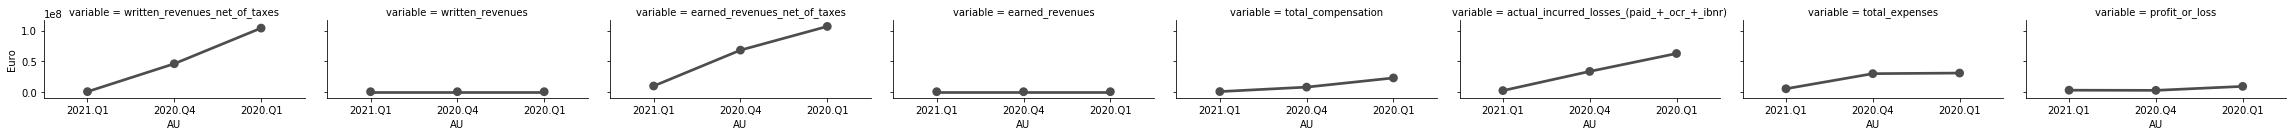

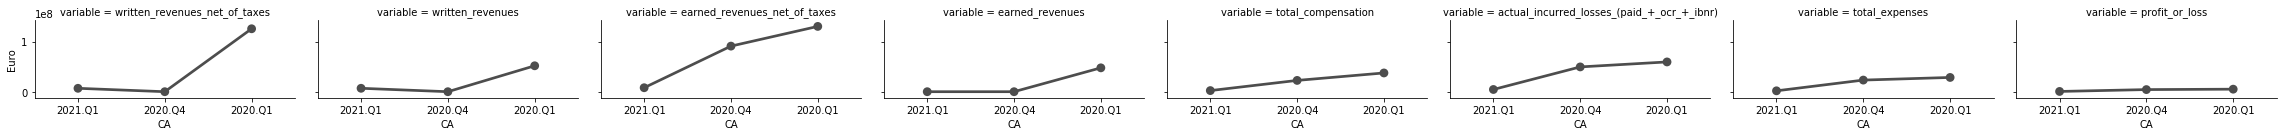

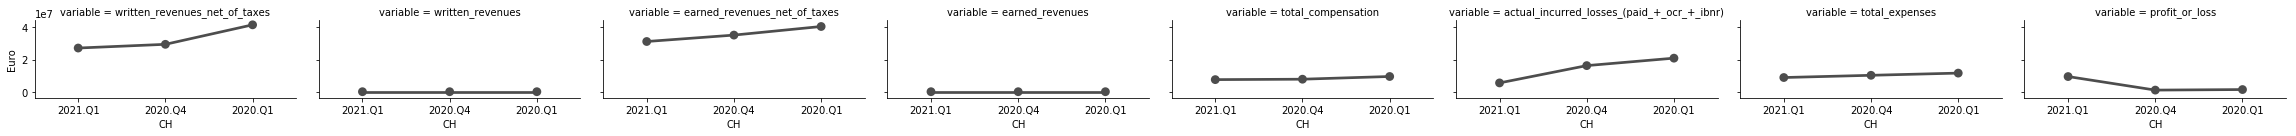

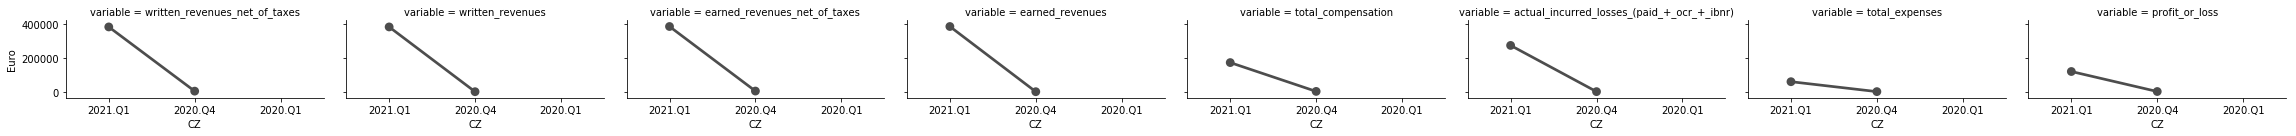

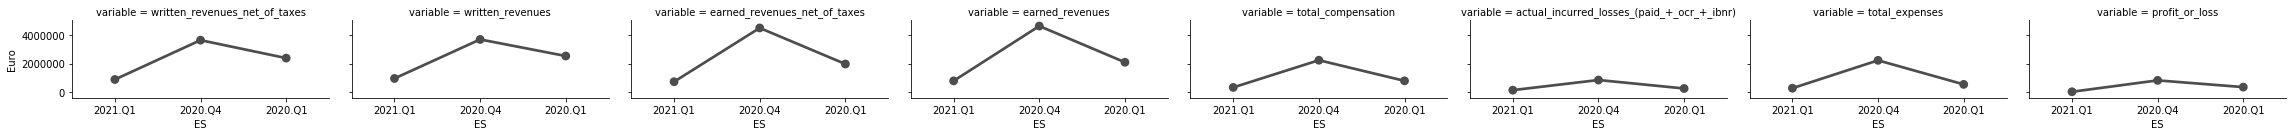

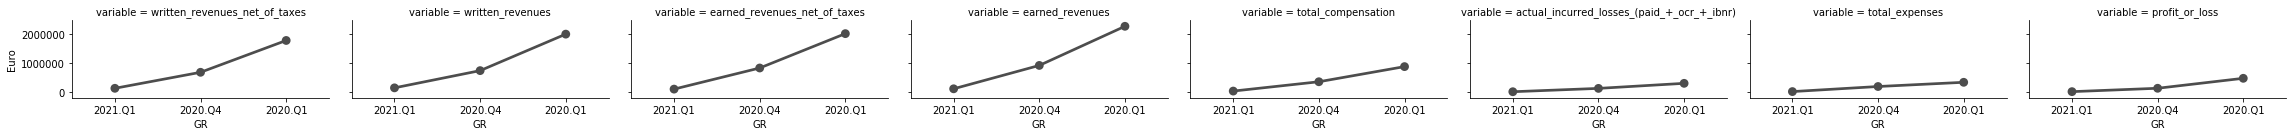

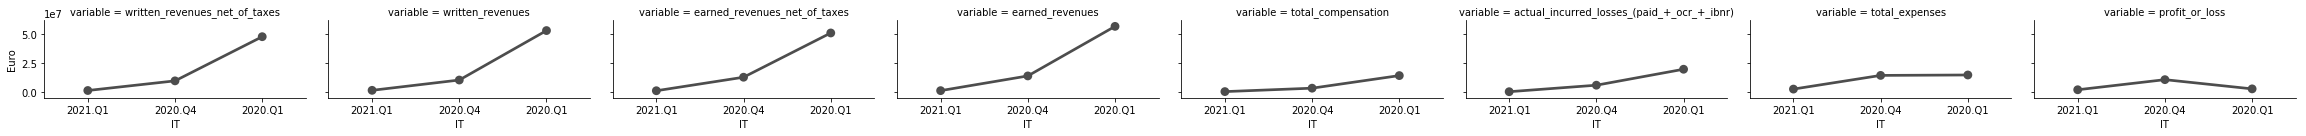

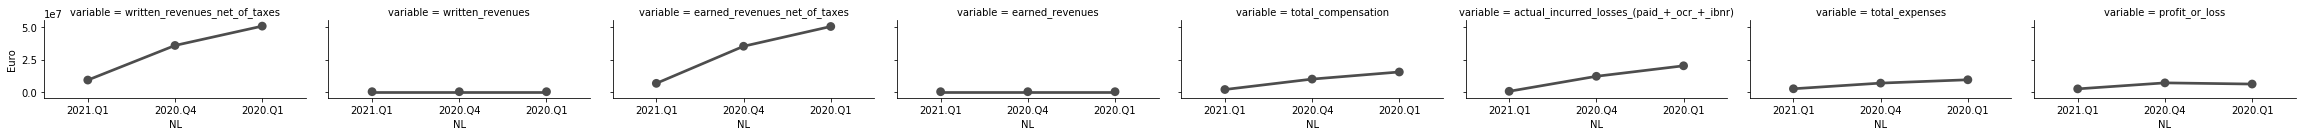

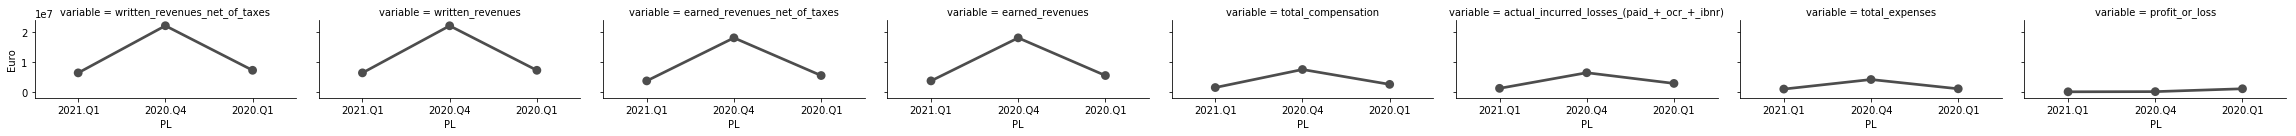

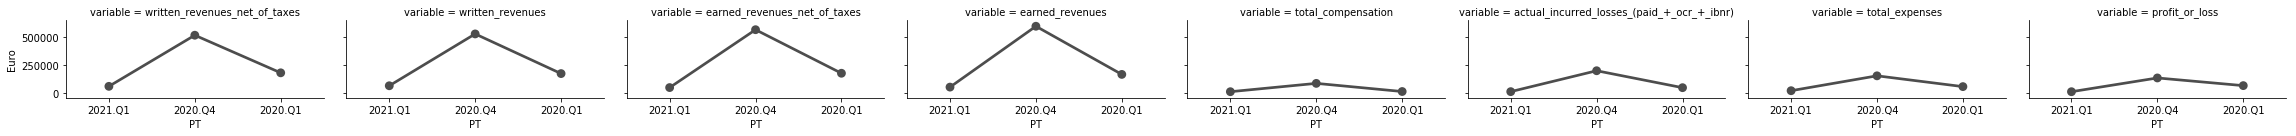

In [225]:

for b in include:

    attend = melt_cv[melt_cv["country"]== b ]
    g = sns.FacetGrid(attend, col="variable", col_wrap=8, height=2,aspect=2,margin_titles=True , legend_out = False)
    g.map(sns.pointplot, "Period", "value", order=order, color=".3", ci=None, label = True)
    axes = g.axes.flatten()
    axes[0].set_ylabel("Euro")
    for ax in axes:
        ax.set_xlabel(b)

Text(6.800000000000004, 0.5, 'Euro')

Text(0.5, 1293.08, 'AU')

Text(0.5, 1293.08, 'AU')

Text(0.5, 1293.08, 'AU')

Text(0.5, 1293.08, 'AU')

Text(0.5, 1293.08, 'AU')

Text(0.5, 1293.08, 'AU')

Text(0.5, 1293.08, 'AU')

Text(0.5, 1293.08, 'AU')

Text(0.5, 1150.1599999999999, 'CA')

Text(0.5, 1150.1599999999999, 'CA')

Text(0.5, 1150.1599999999999, 'CA')

Text(0.5, 1150.1599999999999, 'CA')

Text(0.5, 1150.1599999999999, 'CA')

Text(0.5, 1150.1599999999999, 'CA')

Text(0.5, 1150.1599999999999, 'CA')

Text(0.5, 1150.1599999999999, 'CA')

Text(0.5, 1007.24, 'CH')

Text(0.5, 1007.24, 'CH')

Text(0.5, 1007.24, 'CH')

Text(0.5, 1007.24, 'CH')

Text(0.5, 1007.24, 'CH')

Text(0.5, 1007.24, 'CH')

Text(0.5, 1007.24, 'CH')

Text(0.5, 1007.24, 'CH')

Text(0.5, 864.32, 'CZ')

Text(0.5, 864.32, 'CZ')

Text(0.5, 864.32, 'CZ')

Text(0.5, 864.32, 'CZ')

Text(0.5, 864.32, 'CZ')

Text(0.5, 864.32, 'CZ')

Text(0.5, 864.32, 'CZ')

Text(0.5, 864.32, 'CZ')

Text(0.5, 721.4, 'ES')

Text(0.5, 721.4, 'ES')

Text(0.5, 721.4, 'ES')

Text(0.5, 721.4, 'ES')

Text(0.5, 721.4, 'ES')

Text(0.5, 721.4, 'ES')

Text(0.5, 721.4, 'ES')

Text(0.5, 721.4, 'ES')

Text(0.5, 578.4799999999999, 'GR')

Text(0.5, 578.4799999999999, 'GR')

Text(0.5, 578.4799999999999, 'GR')

Text(0.5, 578.4799999999999, 'GR')

Text(0.5, 578.4799999999999, 'GR')

Text(0.5, 578.4799999999999, 'GR')

Text(0.5, 578.4799999999999, 'GR')

Text(0.5, 578.4799999999999, 'GR')

Text(0.5, 435.55999999999995, 'IT')

Text(0.5, 435.55999999999995, 'IT')

Text(0.5, 435.55999999999995, 'IT')

Text(0.5, 435.55999999999995, 'IT')

Text(0.5, 435.55999999999995, 'IT')

Text(0.5, 435.55999999999995, 'IT')

Text(0.5, 435.55999999999995, 'IT')

Text(0.5, 435.55999999999995, 'IT')

Text(0.5, 292.64000000000004, 'NL')

Text(0.5, 292.64000000000004, 'NL')

Text(0.5, 292.64000000000004, 'NL')

Text(0.5, 292.64000000000004, 'NL')

Text(0.5, 292.64000000000004, 'NL')

Text(0.5, 292.64000000000004, 'NL')

Text(0.5, 292.64000000000004, 'NL')

Text(0.5, 292.64000000000004, 'NL')

Text(0.5, 149.7200000000001, 'PL')

Text(0.5, 149.7200000000001, 'PL')

Text(0.5, 149.7200000000001, 'PL')

Text(0.5, 149.7200000000001, 'PL')

Text(0.5, 149.7200000000001, 'PL')

Text(0.5, 149.7200000000001, 'PL')

Text(0.5, 149.7200000000001, 'PL')

Text(0.5, 149.7200000000001, 'PL')

Text(0.5, 6.800000000000189, 'PT')

Text(0.5, 6.800000000000189, 'PT')

Text(0.5, 6.800000000000189, 'PT')

Text(0.5, 6.800000000000189, 'PT')

Text(0.5, 6.800000000000189, 'PT')

Text(0.5, 6.800000000000189, 'PT')

Text(0.5, 6.800000000000189, 'PT')

Text(0.5, 6.800000000000189, 'PT')

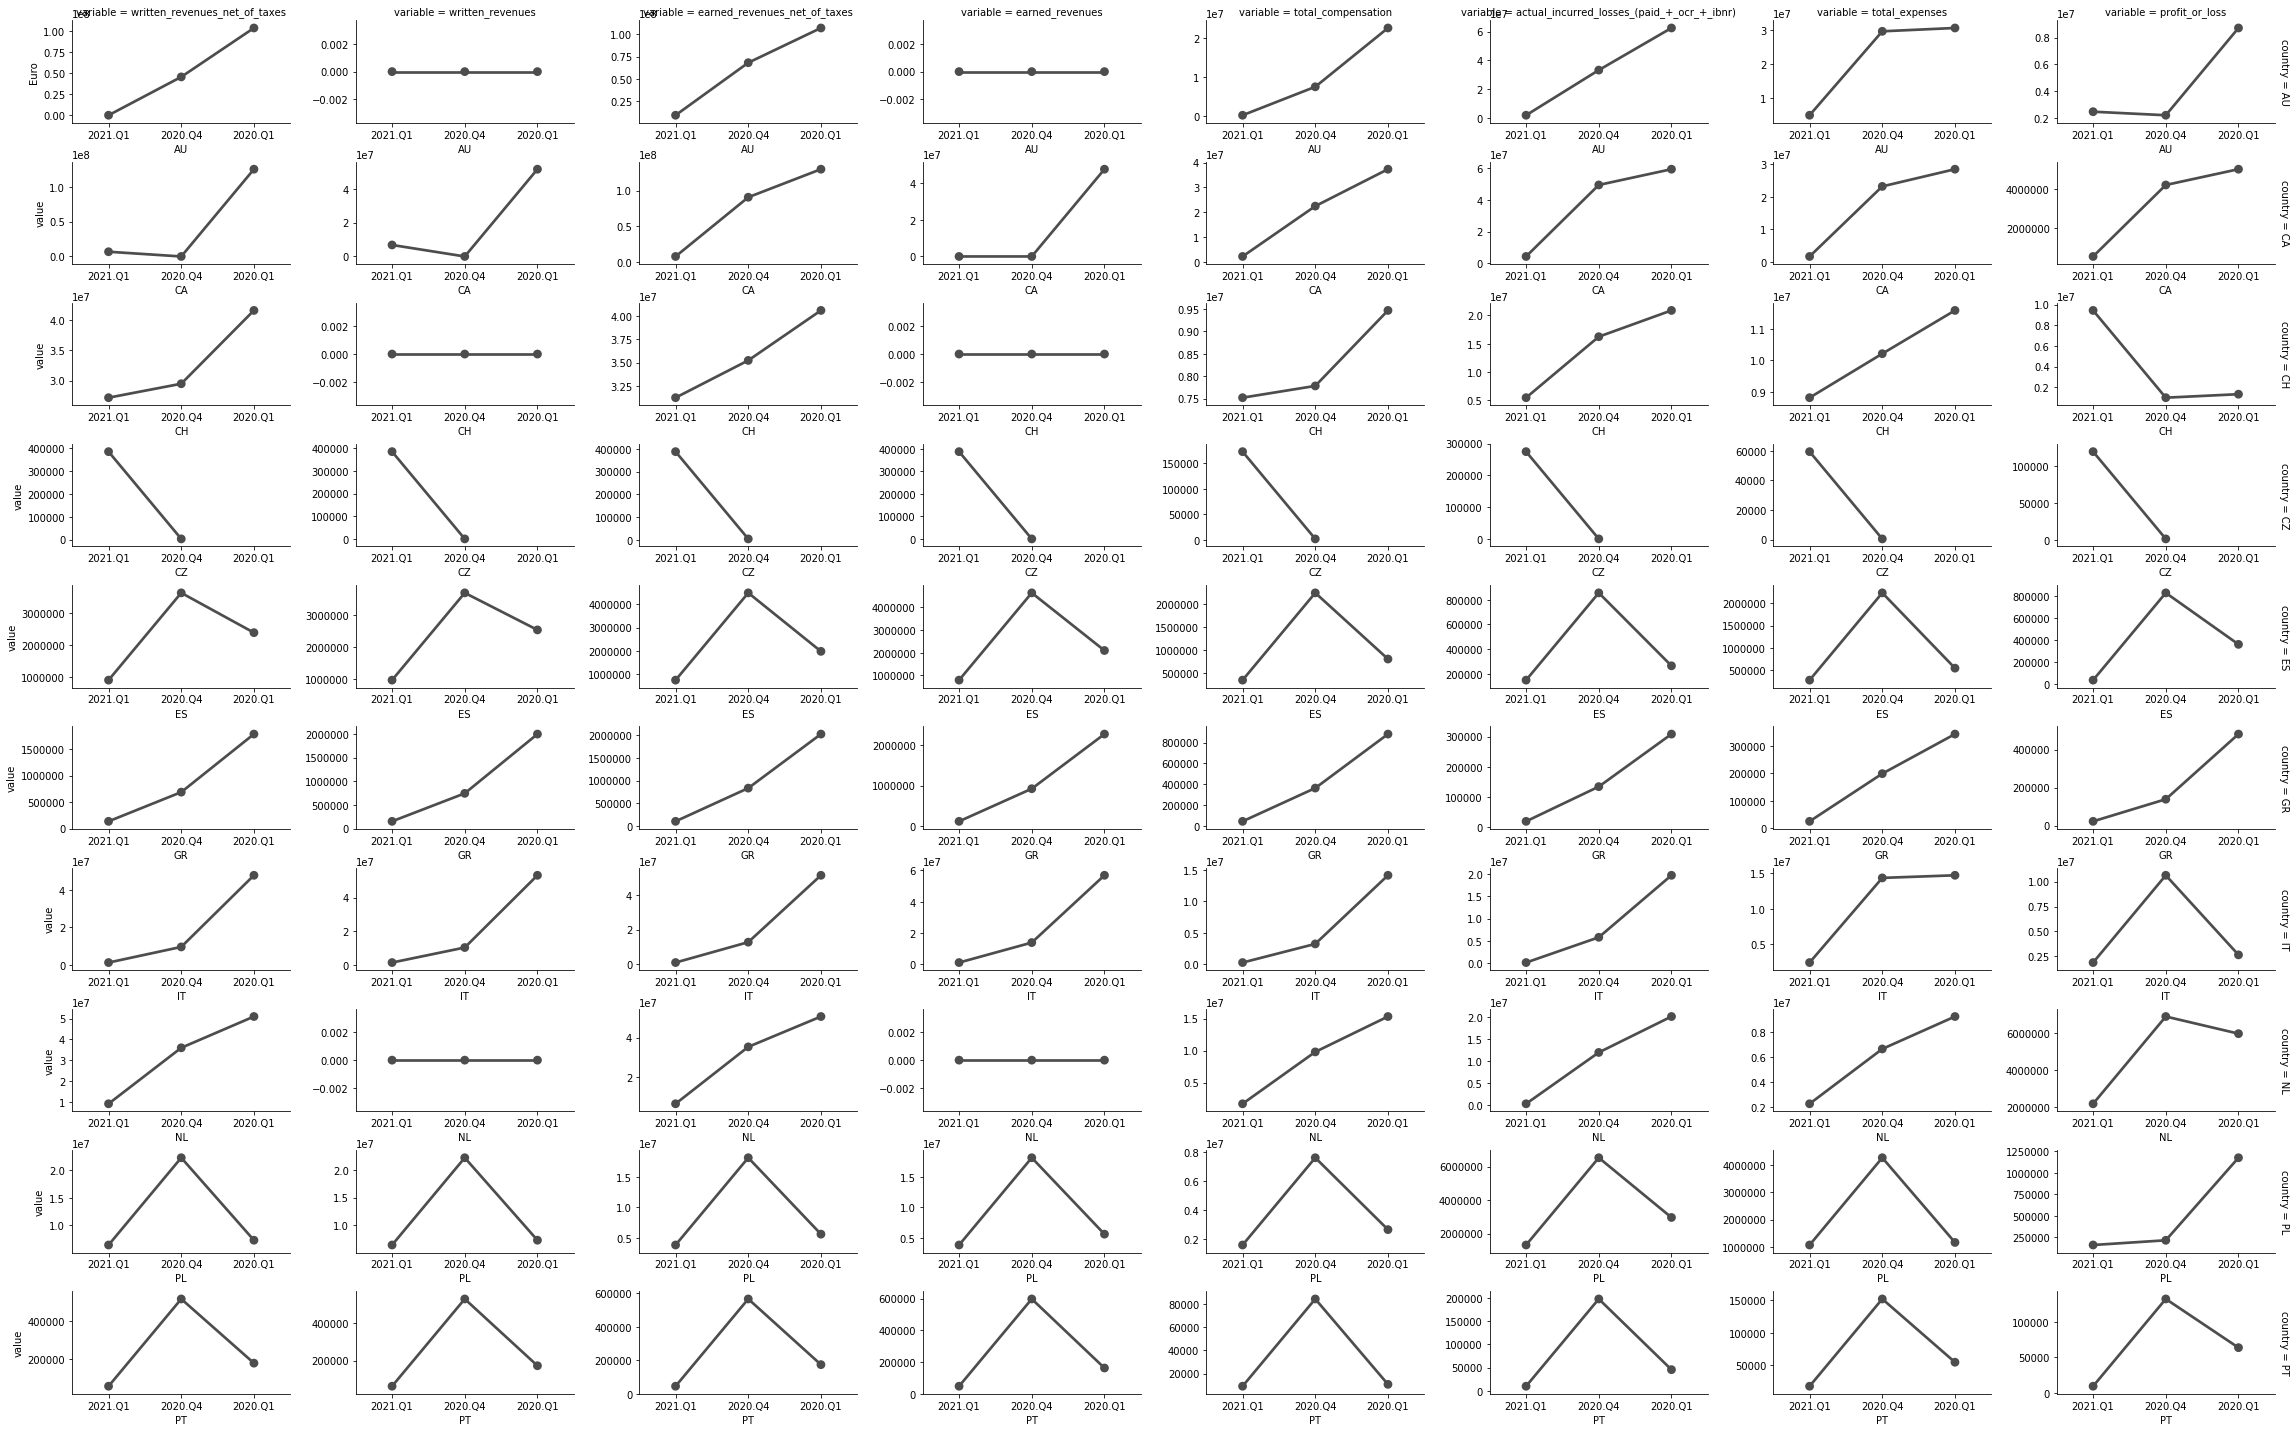

In [250]:
included = (include * 8)
included.sort()

attend = melt_cv
g = sns.FacetGrid(attend, row="country", col="variable", height=2, aspect=2, margin_titles=True, legend_out=False, sharex=False, sharey=False)
g.map(sns.pointplot, "Period", "value", order=order, color=".3", ci=None, label = True)
axes = g.axes.flatten()
axes[0].set_ylabel("Euro")
for ax, b  in zip(axes, included):
    ax.set_xlabel(b)